**1. CNN(なぜ"たたみこむ"のか)**
> 通常のNNでは, 256×256の画像を入力とし, 10出力とすると, 256×256×10のパラメータを要することになる. これは, 複雑になりすぎて, 過学習を引き起こしてしまう.そこでパラメータの数を減らし, 同じパラメータを複数回再利用する方法がCNNである

**2. パラメータを減らす(再利用)とは**
> 256×256の画像があったら, それを区間毎(5×5)で, スライドしながら分別してとらえる.2ピクセルずつ左から右へとスライドするこの2は"スライド長"と言われる.そうすれば, 入力パラメータ数は, 5×5=25しかない.

**3. つまり...たたみこみとは**
> 畳み込みとは, 区間(5×5のような局所的な領域)が画像全体をスライドするときの画像ピクセルの加重和である.

**4. 畳み込み層**
> スライドする区間を重ね合わせる処理は, "畳み込み層"で行う. もちろん, 畳み込みの数(畳み込み層のノードの数)は, 1つとは限らず, 複数(n個)とすると, 5×5×nのテンソルを構築する. つまり, n=64とすると, 5×5の区間をスライドさせることで, 5×5×64個のパラメータをもつことになる. 

**5. CNNの美しいPoint！**
> CNNの最大のPointは, **パラメータの数が元の画像のサイズとは無関係である**ということ. 300×300の元画像でも同じCNNを実行でき, 畳み込み層でパラメータの数は変わらない. だって, パラメータ数は"区間のサイズ"と"畳み込みの数"で決まるから！






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive/Colab Notebooks/春休み課題"

/content/drive/My Drive/Colab Notebooks/春休み課題


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**フィルタの生成**
> **[概念]** フィルタとは, 画像を変換させるもの. フィルタを適用して変換された画像には, 変換前の画像と対応する点が"**特徴**"を表す.

> **[どういうものか]** フィルタはさまざまな種類が存在する.

1.   ランダムフィルタ: 正規分布に従う数字が入っただけの行列
2.   前処理フィルタ: 平均化フィルタ, メディアンフィルタのように, 入力データを加工する式が組み込まれた行列.







In [0]:
#ランダムフィルタの生成と視覚化
W = tf.Variable(tf.random_normal(shape=[5, 5, 1, 32]))  #[縦,横,チャネル数,畳み込み数]

def show_weights(W, filename=None):
  plt.figure()
  rows, cols = 4, 8
  for i in range(np.shape(W)[3]): #32個の画像(=フィルタ)
    img = W[:, :, 0, i]
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap='Greys_r', interpolation='none')
    plt.axis('off')
  if filename:
    plt.savefig(filename)
  else:
    plt.show()

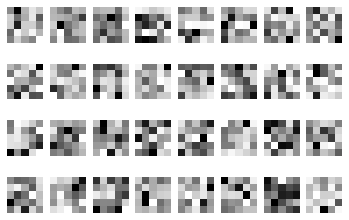

In [10]:
#途中結果(ランダムフィルタの表示)
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  W_val = sess.run(W)
  show_weights(W_val, 'step0_weights.png')

**フィルタを畳みこむ**
> フィルタを畳み込む(スライドさせて加重和を求める)とは, そのフィルタを通して抽出された元画像の特徴を表した画像, つまり, 別の視点から元画像を見ることである.

In [0]:
#畳み込み結果の表示
def show_conv_results(data, filename=None):
  plt.figure()
  rows, cols = 4, 8
  for i in range(np.shape(data)[3]):
    img = data[0, :, :, i]      #ちょっとここ,あとで確認ね!
    plt.subplot(rows, cols, i+1)
    plt.imshow(img, cmap='Greys_r', interpolation='none')
    plt.axis('off')
  if filename:
    plt.savefig(filename)
  else:
    plt.show()


> 複数のフィルタを畳み込む際には, 畳み込み関数(**cov2d関数**)を用いる.
```
tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
x:元画像 [画像の枚数, 縦, 横, チャンネル数]
W:フィルタ [縦, 横, チャンネル数, フィルター数]
strides:[1, dy, dx, 1] 縦方向にdyピクセル毎、横方向にdxピクセル毎
padding:'SAME'だと入力画像と同じ大きさの画像が, 'VALID'だとフィルタの大きさを飛び出るところは,ちょん切られる.
```
con2d関数を用いることで, 今までのようにy=f(wx+b)として, 簡単にできる！



In [13]:
import CIFAR10
names, data, labels = CIFAR10.read_data('cifar-10-batches-py')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/春休み課題
names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(50000, 3072) (50000,)


(1, 24, 24, 32)
(1, 24, 24, 32)


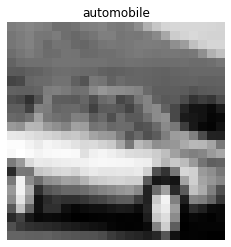

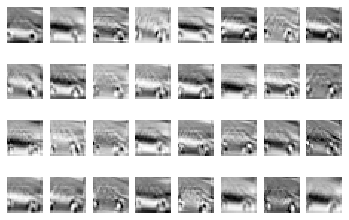

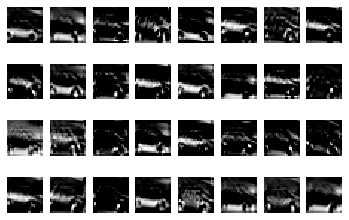

In [25]:
#畳み込みの視覚化
raw_data = data[4,:]   #適当に4番目の画像を1枚を取り出して...
raw_img = np.reshape(raw_data, (24, 24))
plt.figure()           #表示してみる
plt.imshow(raw_img, cmap='Greys_r')
plt.title(names[labels[4]])   #subplotのタイトル
plt.axis('off')
plt.savefig('input_image.png')

x = tf.reshape(raw_data, shape=[-1, 24, 24, 1]) #入力画像をテンソル構築:[画像の枚数,縦,横,チャネル数]
b = tf.Variable(tf.random_normal(shape=[32]))   #畳み込む数(畳み込み層のノード数だけ用意)
conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
conv_with_b = tf.nn.bias_add(conv, b)
conv_out = tf.nn.relu(conv_with_b)   #活性化関数:ReLUにより,非線形性の確保

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  conv_val = sess.run(conv)
  show_conv_results(conv_val, 'step1_convs.png')
  print(np.shape(conv_val))

  conv_out_val = sess.run(conv_out)
  show_conv_results(conv_out_val, 'step2_conv_outs.png')
  print(np.shape(conv_out_val))

**最大プール(Max pooling)**

> 畳み込み層で特徴を抽出した後, 出力サイズを縮小してパラメータの数を減らし, 過学習を防ぐ.

> 最大プール:画像を小さな区画単位で走査して, 最大値をもつピクセルを選択する. 移動幅に応じて結果の画像は元の画像よりも小さくなる.

> 32×32の画像に対して, 2×2のサイズで移動幅が2の場合, 得られる最大プール画像は, 1/4(=1/2×1/2)になるよね！



In [0]:
k = 2
maxpool = tf.nn.max_pool(conv_out, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

with tf.Session() as sess:
  maxpool_val = sess.run(maxpool)
  show_conv_results(maxpool, 'step3_maxpool.png')
  print(np.shape(maxpool_val))